# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [12]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [13]:
data.iloc[18,1]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [6]:
!pip install unidecode

     |████████████████████████████████| 241 kB 4.8 MB/s eta 0:00:01


In [14]:
from unidecode import unidecode
data['verse'] = data['verse'].apply(unidecode)


In [15]:
data.iloc[18,1]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [18]:
data['verse'].duplicated().sum()

946

Yes there are duplicates

In [19]:
data.shape

(3975, 2)

In [22]:
data.drop_duplicates(inplace=True)

In [23]:
data.shape

(3031, 2)

In [24]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [25]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [26]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [27]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [28]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [29]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [30]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [31]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [33]:
data['seq'] = data.verse.apply(text_to_word_sequence)

❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

<AxesSubplot:ylabel='Density'>

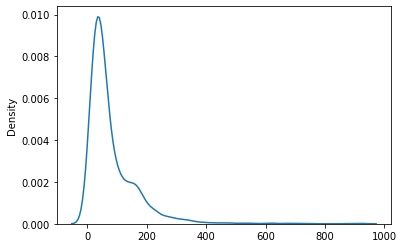

In [39]:
sns.kdeplot([len(data.seq.iloc[i]) for i in range(len(data.seq))])

Yes we can keep only the first 300 words

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [40]:
data['seq'] = data.seq.apply(lambda x : x[:300])

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [45]:
from gensim.models import Word2Vec
#train word2Vec
word2vec = Word2Vec(sentences=data['seq'], epochs=50, vector_size=100, min_count=0 )

In [123]:
def embed_sentence(sentence):
    X=[]
    for word in sentence:
        try:
            X.append(word2vec.wv[word])
        except:
            pass
        
    return np.array(X)

In [124]:
data['embed'] = data.seq.apply(embed_sentence)

In [125]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [154]:
X=[data.embed.iloc[i] for i in range(len(data.embed))]
from tensorflow.keras.preprocessing.sequence import pad_sequences
X=pad_sequences(X, dtype='float32', padding='post', maxlen=300)
X.shape

(3031, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [158]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y=encoder.fit_transform(data[['artist']])
y.shape

(3031, 3)

👉 We train/test split the dataset below for you

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [157]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

In [150]:
# ! wget \
# 'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

--2021-06-29 17:22:24--  https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.90.202
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.90.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727513032 (694M) [application/octet-stream]
Saving to: ‘data_lyrics_solution.pickle’

data_lyrics_solutio  93%[=================>  ] 649.62M  1018KB/s    in 11m 26s 

2021-06-29 17:33:50 (970 KB/s) - Read error at byte 681173636/727513032 (Connection reset by peer). Retrying.

--2021-06-29 17:33:51--  (try: 2)  https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.90.202|:443... connected.
HTTP request sent, awaiting response..

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [159]:
import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)

In [183]:
score_baseline = data.artist.value_counts()[0] / len(data.artist)
score_baseline

0.45892444737710325

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [191]:
from tensorflow.keras import layers
from tensorflow.keras import models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
model = models.Sequential([
        layers.Masking(mask_value=0, input_shape=(300,100)),
        layers.LSTM(units=40, return_sequences=False,activation='tanh'),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(3, activation='softmax')
    ])

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [192]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(patience = 10, restore_best_weights=True, monitor='val_loss')
history = model.fit(X_train, y_train, validation_split=0.3, epochs=50, batch_size=32, callbacks=[es], verbose=1)


Epoch 1/50
53/53 [==============================] - 5s 72ms/step - loss: 1.0565 - accuracy: 0.4499 - val_loss: 0.9910 - val_accuracy: 0.5330
Epoch 2/50
53/53 [==============================] - 3s 61ms/step - loss: 0.9397 - accuracy: 0.5742 - val_loss: 0.9240 - val_accuracy: 0.5687
Epoch 3/50
53/53 [==============================] - 3s 59ms/step - loss: 0.8456 - accuracy: 0.6370 - val_loss: 0.8741 - val_accuracy: 0.5852
Epoch 4/50
53/53 [==============================] - 3s 59ms/step - loss: 0.7434 - accuracy: 0.6872 - val_loss: 0.8274 - val_accuracy: 0.6250
Epoch 5/50
53/53 [==============================] - 3s 60ms/step - loss: 0.6492 - accuracy: 0.7244 - val_loss: 0.8282 - val_accuracy: 0.6332
Epoch 6/50
53/53 [==============================] - 3s 62ms/step - loss: 0.5949 - accuracy: 0.7752 - val_loss: 0.8175 - val_accuracy: 0.6484
Epoch 7/50
53/53 [==============================] - 4s 73ms/step - loss: 0.5124 - accuracy: 0.7947 - val_loss: 0.8002 - val_accuracy: 0.6648
Epoch 8/50
53

❓ **Plot the training and validation losses through training**

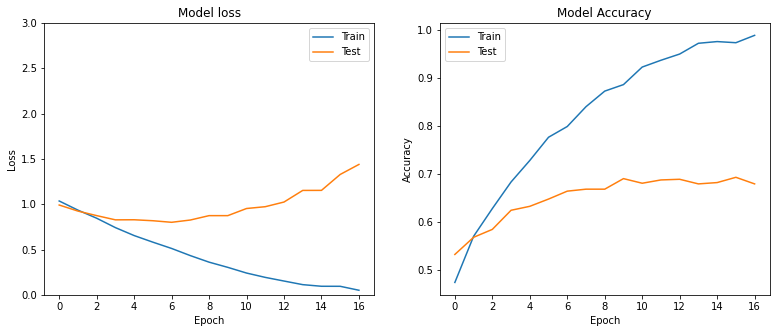

In [195]:
# Plot below your train/val loss history
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim((0,3))
ax[0].legend(['Train', 'Test'], loc='best')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()
    


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)

fig.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [182]:
score_test = model.evaluate(X_test,y_test)[1]
score_test

19/19 [==============================] - 0s 17ms/step - loss: 0.7573 - accuracy: 0.6606


0.6606260538101196

🧪 **Send your results below**

In [184]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()